<a href="https://colab.research.google.com/github/john-yen/DS200/blob/master/F23_Guest_Lecture_Hyper_parameter_Tuning_and_Overfitting_DT_based_Breast_Cancer_Diagnostic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSU DS 200 Section 2
# Fall 2023
# Guest Lecture on Hyper-parameter Tuning and Overfitting Risk: DT-based Cancer Diagnosis

## Instructor: Dr. John Yen

## Learning Objectives

In this lab, you will learn to be able to do the following:
- Tune a hyper-parameter (**max_depth**) of a Decision Tree-based Model to find the best value of the hyper-parameter for the given problem (breast cancer diagnosis).
- Learn a decision tree model for classifying breast cancer data into malignant (class 1) or benign (class 0).
- Evaluate how good is the model (for prediction) using f1 score of testing data (not used for training the model).
- As a learning exercise, record the f1 score of training data as well.
- Compare the f1 score for training data with f1 score for testing data for different hyper-parameter values.
- Identify the hyper-parameter values that demonstrate a risk of **overfitting**.


# Breast Cancer Diagnosis Dataset

The dataset used in this lab is one created for diagnosing whether a tissue image indicates malignant breast cancer or benign.

In [1]:
import datascience
import numpy as np
import graphviz

from datascience import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.base import ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

import pandas as pd
import numpy as np

# from sklearn.externals import joblib

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

In [3]:
# matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/My\ Drive/DS200Labs/

In [5]:
path= "/content/drive/My Drive/DS200Labs/BreatCancerFinal.csv"
BC_table = Table.read_table(path)
BC_table.show(5)

radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,classification
17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,1
20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902,1
19.69,21.25,130,1203,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,1
11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,1
20.29,14.34,135.1,1297,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575,0.1374,0.205,0.4,0.1625,0.2364,0.07678,1


In [6]:
BC_feature_names= BC_table.labels
print(BC_feature_names)
BC_table.num_columns

('radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'classification')


31

In [7]:
# Because the last column is 'classification', which is NOT a feture, but the model's prediction variable, therefore we need to extract the first 30 columns as the list of feature names.
BC_feature_names = BC_feature_names[0:30]
print(BC_feature_names)

('radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst')


## Convert Tables to Data Frame
Like Lab 6, we first convert the final Breast Cancer dataset table to a DataFrame.

In [8]:
# Convert the Breast Cancer Final Table to a Data Frame using .to_df method of Tables in datascience module.
BC_DF= BC_table.to_df()

In [9]:
BC_features = BC_DF.values[:, 0:30]
print(BC_features)

[[  1.79900000e+01   1.03800000e+01   1.22800000e+02 ...,   2.65400000e-01
    4.60100000e-01   1.18900000e-01]
 [  2.05700000e+01   1.77700000e+01   1.32900000e+02 ...,   1.86000000e-01
    2.75000000e-01   8.90200000e-02]
 [  1.96900000e+01   2.12500000e+01   1.30000000e+02 ...,   2.43000000e-01
    3.61300000e-01   8.75800000e-02]
 ..., 
 [  1.40500000e+01   2.71500000e+01   9.13800000e+01 ...,   1.04800000e-01
    2.25000000e-01   8.32100000e-02]
 [  1.12000000e+01   2.93700000e+01   7.06700000e+01 ...,   0.00000000e+00
    1.56600000e-01   5.90500000e-02]
 [  7.76000000e+00   2.45400000e+01   4.79200000e+01 ...,   0.00000000e+00
    2.87100000e-01   7.03900000e-02]]


In [10]:
BC_classification = BC_DF.values[:, 30]
print(BC_classification)
type(BC_classification)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

numpy.ndarray

In [11]:
# Print the total number of labelled data. This way, we can double check the number of training and testing in each fold is correct.
print('Size of Labelled Data: ', len(BC_classification))

Size of Labelled Data:  569


# Split Labelled Data into Training Set and Testing Set



In [12]:
X = BC_features
y = BC_classification

In [13]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 100)

# Hyper-parameter Tuning
The goal of hyper-parameter tuning is to find the best combination of hyper-parameters for a machine learning model (e.g., decision trees in this lab) based on evaluating the learned models using testing data (data NOT used for training the model).

In general, there are more than one hyper-parameters that can be tuned.  For example, we have seen two hyper-parameters for decision trees: ``max_depth``, and ``min_samples_leaf``.

Hyper-parameter tuning consists of two components:
- 1. Iterate through combination of possible hyper-parameter combinations.  A simple way to do this is ``grid search``, which search for all combinations of candidate values of these hyper-parameters.  
- 2. For each hyper-parameter combination, create a machine learning model (e.g., a decision tree in this lab) using the hyper-parameter combination,  and evaluate the model using the testing data (data NOT used for
training the model).

The hyper-parameter combination whose model provides the best evaluation result is then chosen as the **best hyperparameters** to be used for the given machine learning problem.

In this lab, we will tune only one of the hyper-parameters: **max_depth**.

In [14]:
low_max_depth = 2
high_max_depth = 10

## Exercise 1 (1 point)
Complete the following code for tuning the ``max_depth`` hyper-parameter for learning decision trees for breast cancer diagnosis.  We use a table called ``parameter_tuning_table`` to store the f1 scores of the decision trees learned for each value of ``max_depth``.  While only the f1 score for testing data is typically used for choosing the best hyper parameters, we
also compute f1 score for testing data in this lab, for demonstrating/understanding the risk of overfitting. Therefore, the ``parameter_tuning_table`` has three columns:
- max_depth:  An integer (say i) that is the value for the max_depth hyper-parameter.
- f1 of training data: F1 score of training data for the model constructed using the max_depth i.
- f1 of testing data: F1 score of testing data for the model constructed using the max_depth i.

In [15]:
parameter_tuning_table = Table(make_array('max_depth', 'f1 of training data', 'f1 of testing data'))
for i in range(low_max_depth, high_max_depth+1):
  # Create a decision tree template object using i as the max_depth hyper-parameter
  clf = tree.DecisionTreeClassifier(criterion='entropy', random_state = 100, max_depth = i, min_samples_leaf = 0.0001)
  # Train a decision tree model using the template
  clf.fit(X_train, y_train)
  # f1 of training data
  y_train_predict = clf.predict(X_train)
  f1_train = f1_score(y_train, y_train_predict)
  # f1 of testing data
  y_test_predict = clf.predict(X_test)
  f1_test = f1_score(y_test, y_test_predict)
  parameter_tuning_table.append([ i, f1_train, f1_test])

# Access the f1 for training data and f1 for testing data from the parameter_tuning_table


In [16]:
f1_training_array = parameter_tuning_table.column("f1 of training data")
f1_testing_array = parameter_tuning_table.column("f1 of testing data")

In [17]:
max_depth_array = parameter_tuning_table.column("max_depth")

### We want to plot the average of f1 scores (across all k folds) for each max_depth, and compare the average of f1 scores for training data and testing data

In [18]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

In [19]:
 #matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning )

# Exercise 2 (0.5 points)
Complete the following code for plotting f1 training and
f1 testing for different max_depth hyper-parameter used for decision tree learning. There are two ``plot.plot`` commands.  The first one plots the f1 for training data, whereas the second one plots the f1 for testing data. Make sure you enter the correct variable and correct lable in each plot command.

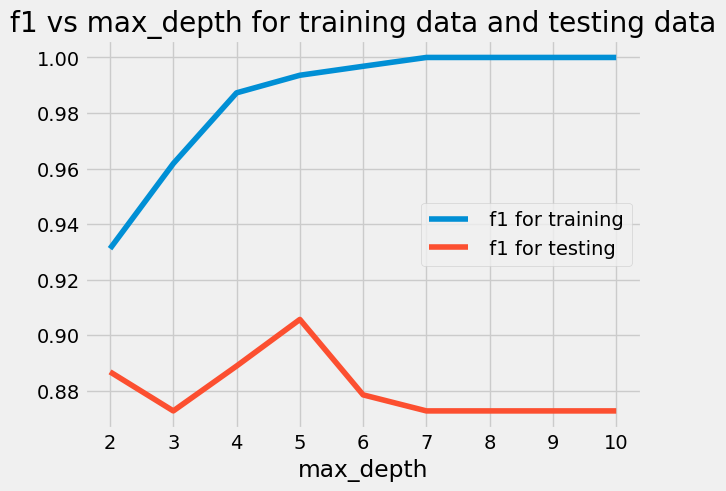

In [20]:
training_label= " f1 for training"
testing_label = " f1 for testing"
plt.plot(max_depth_array, f1_training_array, label= training_label)
plt.plot(max_depth_array, f1_testing_array, label = testing_label)
plt.xlabel('max_depth')
title= 'f1 vs max_depth for training data and testing data'
plt.title(title)
plt.legend()
plt.show()

# Exercise 3 (0.5 points)
Based on the comparison of f1 score for training data and for testing data for different value of max_depth, discuss what values of max_depth lead to models with a high risk of overfitting.

# Answer to Exercise 3
Type your answer here.